In [3]:
import numpy as np 
import scipy 
import pandas as pd 
import os
from utils import *
import shutil
import json

In [2]:
# find all files of TUH - with seizure or not 
# save manifest - nsz, chns (from csv file), sz times, fs

In [3]:
root = '/projectnb/seizuredet/TUH-org/TUH/tuh_seizures/edf/'
patients = []
for name in [ 'train', 'dev', 'eval']:
    patients += os.listdir(root+name+'/01_tcp_ar')  
len(patients)

167

# BIDS conversion

In [4]:
from epilepsy2bids.bids.tuh.convert2bids import convert

In [19]:

save = "/projectnb/seizuredet/TUH-org/tuh-reordered/"
for name in ['train', 'dev', 'eval']:

    subs  = os.listdir(root+name+'/01_tcp_ar/')
    for sub in subs:
        
        patients = os.listdir(root+name+'/01_tcp_ar/'+sub)
        for pt in patients: 
            #if not os.path.exists(save+pt):
            #    os.mkdir(save + pt)
            shutil.copytree(root+name+'/01_tcp_ar/'+sub +'/'+pt , save+'/'+name+'/'+pt)

           

In [ ]:
#trial run of bids
convert('/projectnb/seizuredet/TUH-org/tuh-reordered', 
'/projectnb/seizuredet/Sz-challenge/tuh-bids/unprocessed/')

# Preprocess

In [4]:
# first ensure uniform sampling rate
root = '/projectnb/seizuredet/Sz-challenge/tuh-bids/unprocessed/'
subjects = os.listdir(root)
subjects = list(filter(lambda x: x.startswith('sub-'), subjects))



379

## check sampling frequency

In [7]:
pc, fc = 0,0
for subfol in subjects:
    for sess in os.listdir(root+subfol):

        files = os.listdir(root+subfol+'/'+sess+'/eeg/')
    
        edffiles = list(filter(lambda x: x.endswith('.edf'), files))
        jsonfiles = list(filter(lambda x: x.endswith('.json'), files))
        for fname in jsonfiles:
            with open(root+subfol+'/'+sess+'/eeg/'+fname, 'r') as j:
                fs = json.loads(j.read())['SamplingFrequency']
            #fs = json.loads()
            if fs != 256:
                print(fname, subfol)
            fc += 1
    pc += 1


for subfol in subjects:
    for sess in os.listdir(root+subfol):

        files = os.listdir(root+subfol+'/'+sess+'/eeg/')
        edffiles = list(filter(lambda x: x.endswith('.edf'), files))
        jsonfiles = list(filter(lambda x: x.endswith('.json'), files))
        for fname in edffiles:
            #fs = json.load(root+subfol+'/'+fname)['SamplingFrequency']
            f = pyedflib.EdfReader(root+subfol+'/'+sess+'/eeg/'+fname)
            fs =  np.array(f.getSampleFrequencies())
            if (fs != 256).any():
                print(fname, subfol, fs)
            fc += 1
    pc += 1


## Seizure to no seizure ration

In [20]:
recdict = { 'pt_id': [], 
            'fname': [], 
            'fs': [], 
            'duration': [],
            'nsz': [], 
            'tot_szdur': []
            
}

for subfol in subjects:
    for sess in os.listdir(root+subfol):

        files = os.listdir(root+subfol+'/'+sess+'/eeg/')
        edffiles = list(filter(lambda x: x.endswith('.edf'), files))
        tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
        for fname in tsvfiles:
            data=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+fname,sep='\t')
            recdict['pt_id'].append(subfol)
            recdict['fname'].append(fname)
            recdict['fs'].append(256)
            recdict['duration'].append(data['recordingDuration'][0])
            recdict['nsz'].append((data['eventType']=='sz').sum())
            
            recdict['tot_szdur'].append(data['duration'][data['eventType']=='sz'].sum())
            
recdict = pd.DataFrame(recdict)

In [47]:
print("Total number of recordings: ", len(recdict['duration']))
print("Number Recordings with seizure: ", (np.array(recdict['nsz'])!=0).sum())
print("Total duration: ", np.array(recdict['duration']).sum()/3600, " hours")
print("Seizure duration: ", np.array(recdict['tot_szdur']).sum()/3600, " hours")
print("seizure time ratio: ", np.array(recdict['tot_szdur']).sum()/np.array(recdict['duration']).sum()  )

print("\nConsidering only recordings with seizure")
print("Total duration: ", np.array(recdict['duration'][np.array(recdict['nsz'])!=0]).sum()/3600, " hours")
print("Seizure duration: ", np.array(recdict['tot_szdur'][np.array(recdict['nsz'])!=0]).sum()/3600, " hours")
print("seizure time ratio: ", np.array(recdict['tot_szdur'][np.array(recdict['nsz'])!=0]).sum()/np.array(recdict['duration'][np.array(recdict['nsz'])!=0]).sum()  )
print("Min/Max total duration in seconds", np.array(recdict['duration'][np.array(recdict['nsz'])!=0]).min(), np.array(recdict['duration'][np.array(recdict['nsz'])!=0]).max() )
print("Min/Max seizure duration in seconds", np.array(recdict['tot_szdur'][np.array(recdict['nsz'])!=0]).min(), np.array(recdict['tot_szdur'][np.array(recdict['nsz'])!=0]).max() )


Total number of recordings:  5524
Number Recordings with seizure:  893
Total duration:  1097.5088888888888  hours
Seizure duration:  46.14679166666667  hours
seizure time ratio:  0.042046850038167244

Considering only recordings with seizure
Total duration:  221.40472222222223  hours
Seizure duration:  46.14679166666667  hours
seizure time ratio:  0.2084273144831549
Min/Max total duration in seconds 5.0 3643.0
Min/Max seizure duration in seconds 4.1 2448.0


In [44]:
# load eeg - discard if length<5 min, or no seizure
# preprocess - filter, clip
# crop into 10 min - zero pad , overlap by 2 min
# create labels for every 10. min
# save arrays of eeg and label


4.98

In [47]:
import pyedflib

In [4]:
def EDFRead(filename, ns,
            root_dir = '',
           req_chns = ['FP1','FP2','F7','F3','FZ','F4','F8','T3','C3','CZ','C4','T4','T5','P3','PZ','P4','T6','O1','O2'], 
           ):
    
    f = pyedflib.EdfReader(root_dir+filename)
    n = f.signals_in_file
    data =  {key: None for key in req_chns}
    fs = {key: None for key in req_chns}
    for i in range(n):
        
        chn = str(f.signal_label(i)).split('-')[0].split('\'')[1].upper()
        if chn in req_chns:
           
            data[chn] = f.readSignal(i)                
            fs[chn] = f.getSampleFrequencies()[i]

    f.close()
    for chn in req_chns:
        if fs[chn] == None:                
                data[chn] = np.zeros(ns)
                fs[chn] = fs['FP1']
      
    data = np.array(list(data.values()))
    fs = np.array(list(fs.values()))
    #print(data.shape, fs)
    return data, fs

In [5]:
# def crop(data, fs, duration):


def crop_and_save(data, tsv_data, save_path, subject, session, file_id):
    duration = data.shape[0]
    window = 600  # 10 minutes
    overlap = 120  # 2 minutes
    stride = window - overlap
    leftover = duration % stride
    data_dir = save_path + 'data'
    tsv_dir = save_path + 'annotations'
    
    saved_files = []
    
    for i in range(0, duration, stride):
        end = min(i + window, duration)
        segment = data[i:end]
        
        # Create new tsv for this segment
        seg_tsv = []
        
        # Process each seizure event
        for _, event in tsv_data.iterrows():
            if event['eventType'] == 'bckg':
                continue
                
            sz_start = event['onset']
            sz_end = sz_start + event['duration']
            
            # Check if seizure overlaps with current segment
            if sz_end > i and sz_start < end:
                # Calculate overlap
                overlap_start = max(sz_start, i)
                overlap_end = min(sz_end, end)
                
                # Adjust times relative to segment start
                new_onset = max(0, overlap_start - i)
                new_duration = overlap_end - overlap_start
                
                seg_tsv.append({
                    'onset': new_onset,
                    'duration': new_duration,
                    'eventType': event['eventType'],
                    'confidence': event['confidence'],
                    'channels': event['channels'],
                    'dateTime': event['dateTime'],
                    'recordingDuration': float(window)
                })
        
        # Convert to DataFrame
        if len(seg_tsv) > 0:
            seg_tsv = pd.DataFrame(seg_tsv)
        else:
            # Add background event if no seizures
            seg_tsv = pd.DataFrame([{
                'onset': 0.0,
                'duration': float(window),
                'eventType': 'bckg',
                'confidence': 1.0,
                'channels': 'n/a',
                'dateTime': tsv_data['dateTime'].iloc[0],
                'recordingDuration': float(window)
            }])
        
        # Handle final segment padding if needed
        if end == duration and leftover > 0:
            if leftover < 420:
                if len(seg_tsv[seg_tsv['eventType'] != 'bckg']) > 0:
                    segment = pad_segment(segment)
                else:
                    break
            else:
                segment = pad_segment(segment)
        
        seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
        np.save(data_dir + f"/{seg_name}.npy", segment)
        seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
        saved_files.append(seg_name)
        
    return saved_files

def label_and_save(save_path, segment_name):
    
    label_dir = save_path + 'labels'
    
    labels = np.zeros(600)
    tsv_data = pd.read_csv(f"{save_path}annotations/{segment_name}.tsv", sep='\t')
    for _, row in tsv_data.iterrows():
        if row['eventType'] != 'bckg':
            start = int(row['onset'])
            end = int((row['onset'] + row['duration']))
            if start < len(labels):
                labels[start:min(end, len(labels))] = 1
                
    np.save(label_dir + f"/{segment_name}_labels.npy", labels)



def pad_segment(data):
    
    duration = data.shape[0]
    if duration >= 600:
        return data
        
    pad_length = 600 - duration
    padding = np.zeros((pad_length, 19, 256))
    
    padded_data = np.concatenate([data, padding], axis=0)
    
    return padded_data

def prepare(dataset):
    sampling_rate = 256

    root = f'/projectnb/seizuredet/Sz-challenge/{dataset}/unprocessed/'
    save = f'/projectnb/seizuredet/Sz-challenge/{dataset}/processed/'


    subjects = os.listdir(root)
    subjects = list(filter(lambda x: x.startswith('sub-'), subjects))
    count = 0
    for subfol in subjects:
        for sess in os.listdir(root+subfol):
            files = os.listdir(root+subfol+'/'+sess+'/eeg/')
            os.makedirs(save+'data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'labels/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'annotations/'+subfol+'/'+sess+'/', exist_ok=True)
            edffiles = list(filter(lambda x: x.endswith('.edf'), files))
            tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
            edffiles = sorted(edffiles)
            tsvfiles = sorted(tsvfiles)
            for curredf, currtsv in zip(edffiles, tsvfiles):
                df=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+currtsv,sep='\t')
                duration = df['recordingDuration'][0]
                if (df['eventType']!='bckg').sum() == 0 or duration > 10000:
                    continue #discard if no seizure or duration < 5 min
                
                x = curredf.split('.')[0].split('_')
                print(x[0], x[1], x[3], duration)
                ns = int(duration * sampling_rate)
                data, _ = EDFRead(curredf.split("eeg/")[0], ns, root+subfol+'/'+sess+'/eeg/')
                

                data = preprocess(data, 256)
                # print(data.shape)
                data = data.reshape(data.shape[0], int(duration), sampling_rate).transpose(1,0,2)
                # print(data.shape)


                if data.shape[0] < 600:
                    data = pad_segment(data)
                    df['recordingDuration'] = 600.



                    label = np.zeros(600)
                    for _, row in df.iterrows():
                        if row['eventType'] != 'bckg':
                            start = int(row['onset'])
                            end = int(row['onset'] + row['duration'])
                            label[start:min(end, 600)] = 1


                    np.save(save+'labels/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'_labels.npy', label)
                    np.save(save+'data/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'.npy', data)
                    df.to_csv(save+'annotations/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'.tsv', sep='\t', index=False)

                else:
                    files = crop_and_save(data, df, save, subfol, sess, curredf.split('.')[0])
                    for f in files:
                        label_and_save(save, f)

            
                



                
                

In [6]:
prepare('siena-bids')

sub-13 ses-01 run-00 9355.0
sub-13 ses-01 run-01 9312.0
sub-06 ses-01 run-00 9615.0
sub-06 ses-01 run-02 8180.0
sub-06 ses-01 run-03 7025.0
sub-06 ses-01 run-04 6022.0
sub-12 ses-01 run-00 9774.0
sub-12 ses-01 run-01 1989.0
sub-17 ses-01 run-00 9277.0
sub-17 ses-01 run-01 9172.0
sub-00 ses-01 run-00 2625.0
sub-00 ses-01 run-01 2302.0
sub-00 ses-01 run-02 2509.0
sub-00 ses-01 run-03 2102.0
sub-00 ses-01 run-04 2143.0
sub-05 ses-01 run-00 9245.0
sub-05 ses-01 run-01 7554.0
sub-05 ses-01 run-02 4928.0
sub-11 ses-01 run-00 8677.0
sub-16 ses-01 run-00 8270.0
sub-16 ses-01 run-01 9297.0
sub-09 ses-01 run-00 8233.0
sub-09 ses-01 run-01 8353.0
sub-09 ses-01 run-02 8065.0
sub-10 ses-01 run-00 9982.0
sub-10 ses-01 run-01 8565.0
sub-10 ses-01 run-02 8554.0
sub-10 ses-01 run-03 8713.0
sub-14 ses-01 run-00 7868.0
sub-14 ses-01 run-01 9165.0


In [ ]:
prepare('tuh-bids')

sub-333 ses-00 run-01 1203.0
sub-308 ses-01 run-01 1299.0
sub-358 ses-00 run-01 1476.0
sub-358 ses-01 run-01 158.0
sub-358 ses-01 run-02 142.0
sub-358 ses-01 run-03 601.0
sub-358 ses-01 run-04 601.0
sub-358 ses-01 run-05 850.0
sub-358 ses-01 run-06 531.0
sub-358 ses-01 run-08 601.0
sub-358 ses-01 run-11 1030.0
sub-358 ses-01 run-12 300.0
sub-358 ses-01 run-13 300.0
sub-044 ses-00 run-01 1208.0
sub-094 ses-01 run-01 305.0
sub-094 ses-01 run-02 270.0
sub-133 ses-00 run-02 1258.0
sub-306 ses-00 run-01 1228.0
sub-356 ses-00 run-01 1776.0
sub-356 ses-00 run-02 449.0
sub-042 ses-00 run-01 23.0
sub-092 ses-00 run-02 300.0
sub-092 ses-00 run-03 274.0
sub-092 ses-00 run-04 1269.0
sub-092 ses-00 run-05 632.0
sub-092 ses-00 run-06 300.0
sub-092 ses-00 run-07 642.0
sub-092 ses-00 run-08 616.0
sub-181 ses-00 run-01 946.0
sub-181 ses-00 run-02 558.0
sub-220 ses-00 run-02 5.0
sub-270 ses-00 run-01 1119.0
sub-304 ses-03 run-01 3600.0
sub-304 ses-03 run-02 160.0
sub-304 ses-03 run-03 1634.0
sub-304 ses

In [ ]:
###### 11 recordings in siena and 13 recordings in tuh with duration > 10000



# train deepsoz
# software - for every test sample - preprocess and print tsv. Get metrics

In [ ]:
# get label percentage from all label files for tuh-bids
import os
import numpy as np

root = '/projectnb/seizuredet/Sz-challenge/tuh-bids/processed/'
subjects = os.listdir(root+'labels/')
subjects = list(filter(lambda x: x.startswith('sub-'), subjects))
total = 0
sz = 0
for subfol in subjects:
    for sess in os.listdir(root+'labels/'+subfol):
        files = os.listdir(root+'labels/'+subfol+'/'+sess)
        for file in files:
            data = np.load(root+'labels/'+subfol+'/'+sess+'/'+file)
            sz += data.sum()
            total += len(data)
root = '/projectnb/seizuredet/Sz-challenge/siena-bids/processed/'
subjects = os.listdir(root+'labels/')
subjects = list(filter(lambda x: x.startswith('sub-'), subjects))

for subfol in subjects:
    for sess in os.listdir(root+'labels/'+subfol):
        files = os.listdir(root+'labels/'+subfol+'/'+sess)
        for file in files:
            data = np.load(root+'labels/'+subfol+'/'+sess+'/'+file)
            sz += data.sum()
            total += len(data)
print(sz, total, sz/total)

# 15% together

196889.0 1306200 0.15073419078242228


In [1]:
import os
import numpy as np

root = '/projectnb/seizuredet/Sz-challenge/tuh-bids/processed/'
subjects = os.listdir(root+'labels/')
subjects = list(filter(lambda x: x.startswith('sub-'), subjects))
total = 0
sz = 0
for subfol in subjects:
    for sess in os.listdir(root+'labels/'+subfol):
        files = os.listdir(root+'labels/'+subfol+'/'+sess)
        for file in files:
            data = np.load(root+'labels/'+subfol+'/'+sess+'/'+file)
            sz += data.sum()
            total += len(data)
print(sz, total, sz/total)

# 18%

194409.0 1047600 0.18557560137457044


In [3]:
# get label percentage from all label files for siena-bids
import os
import numpy as np

root = '/projectnb/seizuredet/Sz-challenge/siena-bids/processed/'
subjects = os.listdir(root+'labels/')
subjects = list(filter(lambda x: x.startswith('sub-'), subjects))
total = 0
sz = 0
for subfol in subjects:
    for sess in os.listdir(root+'labels/'+subfol):
        files = os.listdir(root+'labels/'+subfol+'/'+sess)
        for file in files:
            data = np.load(root+'labels/'+subfol+'/'+sess+'/'+file)
            sz += data.sum()
            total += len(data)
print(sz, total, sz/total)

# 0.9 percent

2480.0 258600 0.009590100541376644


In [5]:
# using manifest.csv, calculate number of total siena recordings, total tuh recordings, siena files with seizures, and tuh files with seizures
import pandas as pd
import os
manifest = pd.read_csv('/projectnb/seizuredet/Sz-challenge/code/manifest.csv')
siena = manifest[manifest['dataset']=='siena-bids']
tuh = manifest[manifest['dataset']=='tuh-bids']
print("Total siena recordings with seizures: ", len(siena[siena['nsz']>0]))
print("Total siena recordings: ", len(siena))
print("Total tuh recordings with seizures: ", len(tuh[tuh['nsz']>0]))

print("Total tuh recordings: ", len(tuh))


Total siena recordings with seizures:  45
Total siena recordings:  431
Total tuh recordings with seizures:  1536
Total tuh recordings:  1746


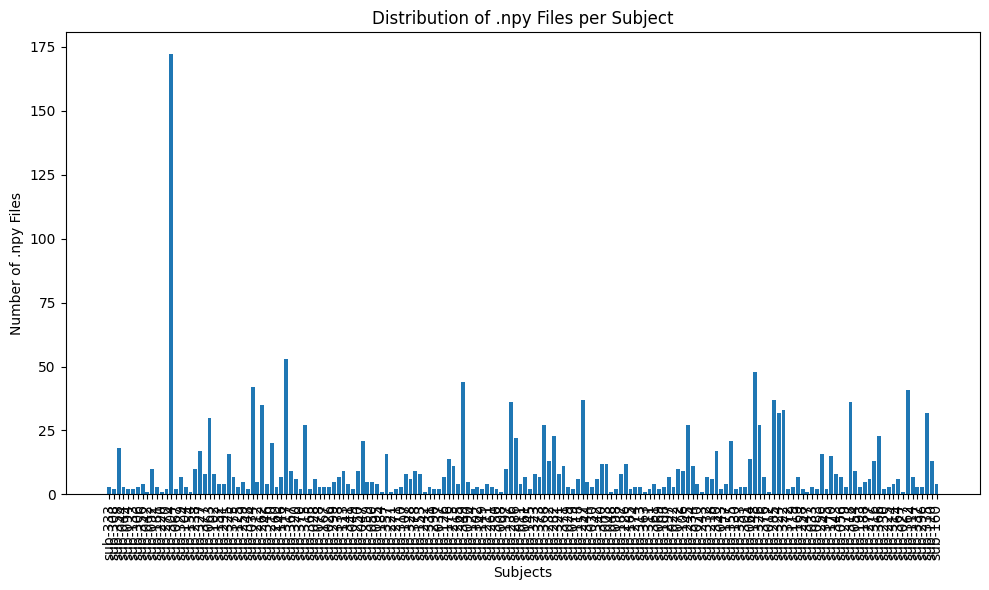

['sub-333',
 'sub-308',
 'sub-358',
 'sub-044',
 'sub-094',
 'sub-133',
 'sub-306',
 'sub-356',
 'sub-042',
 'sub-092',
 'sub-181',
 'sub-220',
 'sub-270',
 'sub-304',
 'sub-067',
 'sub-329',
 'sub-104',
 'sub-154',
 'sub-238',
 'sub-327',
 'sub-377',
 'sub-063',
 'sub-102',
 'sub-152',
 'sub-291',
 'sub-325',
 'sub-375',
 'sub-125',
 'sub-259',
 'sub-348',
 'sub-034',
 'sub-212',
 'sub-262',
 'sub-346',
 'sub-210',
 'sub-260',
 'sub-146',
 'sub-317',
 'sub-367',
 'sub-320',
 'sub-370',
 'sub-315',
 'sub-365',
 'sub-028',
 'sub-078',
 'sub-167',
 'sub-026',
 'sub-299',
 'sub-338',
 'sub-113',
 'sub-341',
 'sub-049',
 'sub-250',
 'sub-047',
 'sub-359',
 'sub-050',
 'sub-095',
 'sub-184',
 'sub-357',
 'sub-221',
 'sub-271',
 'sub-310',
 'sub-107',
 'sub-328',
 'sub-378',
 'sub-153',
 'sub-242',
 'sub-331',
 'sub-290',
 'sub-037',
 'sub-126',
 'sub-176',
 'sub-215',
 'sub-265',
 'sub-349',
 'sub-090',
 'sub-124',
 'sub-302',
 'sub-149',
 'sub-211',
 'sub-261',
 'sub-350',
 'sub-008',
 'su

In [1]:
import os
import matplotlib.pyplot as plt

# Define the folder structure
base_path = "/projectnb/seizuredet/Sz-challenge/tuh-bids/processed/data"

# List to store subjects with .npy files
subjects_with_files = []
subject_file_counts = {}

# Traverse the directory
for subject in os.listdir(base_path):
    subject_path = os.path.join(base_path, subject)
    if os.path.isdir(subject_path):
        total_files = 0
        has_files = False
        for session in os.listdir(subject_path):
            session_path = os.path.join(subject_path, session)
            if os.path.isdir(session_path):
                npy_files = [file for file in os.listdir(session_path) if file.endswith('.npy')]
                total_files += len(npy_files)
                if npy_files:
                    has_files = True
        if has_files:
            subjects_with_files.append(subject)
            subject_file_counts[subject] = total_files

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(subject_file_counts.keys(), subject_file_counts.values())
plt.xlabel('Subjects')
plt.ylabel('Number of .npy Files')
plt.title('Distribution of .npy Files per Subject')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
subjects_with_files

In [2]:
import numpy as np
subjects_with_files.remove('sub-304')
subjects_with_files.remove('sub-324')
subjects_with_files = np.array(subjects_with_files)
np.save('/projectnb/seizuredet/Sz-challenge/code/subjects_with_files.npy', subjects_with_files)


In [5]:
import numpy as np
import random
subjects_with_files = np.load('/projectnb/seizuredet/Sz-challenge/code/subjects_with_files.npy', allow_pickle=True)
subjects_with_files = subjects_with_files.tolist()

# shuffle subjects_with_files
random.shuffle(subjects_with_files)
ptlist = np.array(subjects_with_files)
np.save('/projectnb/seizuredet/Sz-challenge/code/ptlist.npy', ptlist)

In [6]:
print(len(ptlist))

172


In [7]:
import numpy as np
data = np.load('/projectnb/seizuredet/Sz-challenge/tuh-bids/processed/data/sub-330/ses-02/sub-330_ses-02_task-szMonitoring_run-02_eeg_seg001.npy')
print(data.shape)
labels = np.load('/projectnb/seizuredet/Sz-challenge/tuh-bids/processed/labels/sub-330/ses-02/sub-330_ses-02_task-szMonitoring_run-02_eeg_seg001_labels.npy')   
print(labels.shape)
print(labels)



(600, 19, 256)
(600,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [8]:
# i forgot to zero pad the data itself, i only zero padded the labels

import numpy as np
import os
import shutil

root = '/projectnb/seizuredet/Sz-challenge/siena-bids/processed/'
subjects = os.listdir(root+'data/')
subjects = list(filter(lambda x: x.startswith('sub-'), subjects))
for subfol in subjects:
    for sess in os.listdir(root+'data/'+subfol):
        files = os.listdir(root+'data/'+subfol+'/'+sess)
        for file in files:
            data = np.load(root+'data/'+subfol+'/'+sess+'/'+file)
            if data.shape[0] < 600:
                data = np.pad(data, ((0, 600-data.shape[0]), (0,0), (0,0)))
                np.save(root+'data/'+subfol+'/'+sess+'/'+file, data)

print('done')

done


In [ ]:
# full preprocess function:
import numpy as np 
import pandas as pd 
import os
from utils import *


def EDFRead(filename, ns,
            root_dir = '',
           req_chns = ['FP1','FP2','F7','F3','FZ','F4','F8','T3','C3','CZ','C4','T4','T5','P3','PZ','P4','T6','O1','O2'], 
           ):
    
    f = pyedflib.EdfReader(root_dir+filename)
    n = f.signals_in_file
    data =  {key: None for key in req_chns}
    fs = {key: None for key in req_chns}
    for i in range(n):
        
        chn = str(f.signal_label(i)).split('-')[0].split('\'')[1].upper()
        if chn in req_chns:
           
            data[chn] = f.readSignal(i)                
            fs[chn] = f.getSampleFrequencies()[i]

    f.close()
    for chn in req_chns:
        if fs[chn] == None:                
                data[chn] = np.zeros(ns)
                fs[chn] = fs['FP1']
      
    data = np.array(list(data.values()))
    fs = np.array(list(fs.values()))
    #print(data.shape, fs)
    return data, fs

# def crop(data, fs, duration):


def crop_and_save(data, tsv_data, save_path, subject, session, file_id):
    duration = data.shape[0]
    window = 600  # 10 minutes
    overlap = 120  # 2 minutes
    stride = window - overlap
    leftover = duration % stride
    data_dir = save_path + 'data'
    tsv_dir = save_path + 'annotations'
    
    saved_files = []
    
    for i in range(0, duration, stride):
        end = min(i + window, duration)
        segment = data[i:end]
        
        # Create new tsv for this segment
        seg_tsv = []
        
        # Process each seizure event
        for _, event in tsv_data.iterrows():
            if event['eventType'] == 'bckg':
                continue
                
            sz_start = event['onset']
            sz_end = sz_start + event['duration']
            
            # Check if seizure overlaps with current segment
            if sz_end > i and sz_start < end:
                # Calculate overlap
                overlap_start = max(sz_start, i)
                overlap_end = min(sz_end, end)
                
                # Adjust times relative to segment start
                new_onset = max(0, overlap_start - i)
                new_duration = overlap_end - overlap_start
                
                seg_tsv.append({
                    'onset': new_onset,
                    'duration': new_duration,
                    'eventType': event['eventType'],
                    'confidence': event['confidence'],
                    'channels': event['channels'],
                    'dateTime': event['dateTime'],
                    'recordingDuration': float(window)
                })
        
        # Convert to DataFrame
        if len(seg_tsv) > 0:
            seg_tsv = pd.DataFrame(seg_tsv)
        else:
            # Add background event if no seizures
            seg_tsv = pd.DataFrame([{
                'onset': 0.0,
                'duration': float(window),
                'eventType': 'bckg',
                'confidence': 1.0,
                'channels': 'n/a',
                'dateTime': tsv_data['dateTime'].iloc[0],
                'recordingDuration': float(window)
            }])
        
        # Handle final segment padding if needed
        if end == duration and leftover > 0:
            if leftover < 420:
                if len(seg_tsv[seg_tsv['eventType'] != 'bckg']) > 0:
                    segment = pad_segment(segment)
                else:
                    break
            else:
                segment = pad_segment(segment)
        
        seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
        np.save(data_dir + f"/{seg_name}.npy", segment)
        seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
        saved_files.append(seg_name)
        
    return saved_files

def label_and_save(save_path, segment_name):
    
    label_dir = save_path + 'labels'
    
    labels = np.zeros(600)
    tsv_data = pd.read_csv(f"{save_path}annotations/{segment_name}.tsv", sep='\t')
    for _, row in tsv_data.iterrows():
        if row['eventType'] != 'bckg':
            start = int(row['onset'])
            end = int((row['onset'] + row['duration']))
            if start < len(labels):
                labels[start:min(end, len(labels))] = 1
                
    np.save(label_dir + f"/{segment_name}_labels.npy", labels)



def pad_segment(data):
    
    duration = data.shape[0]
    if duration >= 600:
        return data
        
    pad_length = 600 - duration
    padding = np.zeros((pad_length, 19, 256))
    
    padded_data = np.concatenate([data, padding], axis=0)
    
    return padded_data

def prepare(dataset):
    sampling_rate = 256

    root = f'/projectnb/seizuredet/Sz-challenge/{dataset}/unprocessed/'
    save = f'/projectnb/seizuredet/Sz-challenge/{dataset}/processed/'


    subjects = os.listdir(root)
    subjects = list(filter(lambda x: x.startswith('sub-'), subjects))
    count = 0
    for subfol in subjects:
        for sess in os.listdir(root+subfol):
            files = os.listdir(root+subfol+'/'+sess+'/eeg/')
            os.makedirs(save+'data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'labels/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'annotations/'+subfol+'/'+sess+'/', exist_ok=True)
            edffiles = list(filter(lambda x: x.endswith('.edf'), files))
            tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
            edffiles = sorted(edffiles)
            tsvfiles = sorted(tsvfiles)
            for curredf, currtsv in zip(edffiles, tsvfiles):
                df=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+currtsv,sep='\t')
                duration = df['recordingDuration'][0]
                if (df['eventType']!='bckg').sum() == 0 or duration > 10000:
                    continue #discard if no seizure or duration < 5 min
                
                x = curredf.split('.')[0].split('_')
                print(x[0], x[1], x[3], duration)
                ns = int(duration * sampling_rate)
                data, _ = EDFRead(curredf.split("eeg/")[0], ns, root+subfol+'/'+sess+'/eeg/')
                

                data = preprocess(data, 256)
                # print(data.shape)
                data = data.reshape(data.shape[0], int(duration), sampling_rate).transpose(1,0,2)
                # print(data.shape)


                if data.shape[0] < 600:
                    data = pad_segment(data)
                    df['recordingDuration'] = 600.



                    label = np.zeros(600)
                    for _, row in df.iterrows():
                        if row['eventType'] != 'bckg':
                            start = int(row['onset'])
                            end = int(row['onset'] + row['duration'])
                            label[start:min(end, 600)] = 1


                    np.save(save+'labels/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'_labels.npy', label)
                    np.save(save+'data/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'.npy', data)
                    df.to_csv(save+'annotations/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'.tsv', sep='\t', index=False)

                else:
                    files = crop_and_save(data, df, save, subfol, sess, curredf.split('.')[0])
                    for f in files:
                        label_and_save(save, f)

            
                
def main():
    prepare('siena-bids')
    prepare('tuh-bids')


                

if __name__ == '__main__':
    main()